# Project: Wrangling and Analyze Data

## Data Gathering

In [1]:
import pandas as pd
import requests
import tweepy
import json
import time
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import json
import os
import collections
from timeit import default_timer as timer
%matplotlib inline

In [2]:
archive=pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
# Import the tweet image predictions TSV file into a DataFrame
img_df = pd.read_csv('image_predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
# Declare Twitter API keys and access tokens
consumer_key = '******'
consumer_secret = '******'
access_token = '******'
access_secret = '******'

In [6]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [7]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
start = time.time() # start timer

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = archive.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        
end = time.time() # end timer
print((end - start)/(1000*60))

1# 892420643555336193
2# 892177421306343426
3# 891815181378084864
4# 891689557279858688
5# 891327558926688256
6# 891087950875897856
7# 890971913173991426
8# 890729181411237888
9# 890609185150312448
10# 890240255349198849
11# 890006608113172480
12# 889880896479866881
13# 889665388333682689
14# 889638837579907072
15# 889531135344209921
16# 889278841981685760
17# 888917238123831296
18# 888804989199671297
19# 888554962724278272
20# 888202515573088257
888202515573088257: No status found with that ID.

21# 888078434458587136
22# 887705289381826560
23# 887517139158093824
24# 887473957103951883
25# 887343217045368832
26# 887101392804085760
27# 886983233522544640
28# 886736880519319552
29# 886680336477933568
30# 886366144734445568
31# 886267009285017600
32# 886258384151887873
33# 886054160059072513
34# 885984800019947520
35# 885528943205470208
36# 885518971528720385
37# 885311592912609280
38# 885167619883638784
39# 884925521741709313
40# 884876753390489601
41# 884562892145688576
42# 88444180538

313# 835264098648616962
314# 835246439529840640
315# 835172783151792128
316# 835152434251116546
317# 834931633769889797
318# 834786237630337024
319# 834574053763584002
320# 834477809192075265
321# 834458053273591808
322# 834209720923721728
323# 834167344700198914
324# 834089966724603904
325# 834086379323871233
326# 833863086058651648
327# 833826103416520705
328# 833732339549220864
329# 833722901757046785
330# 833479644947025920
331# 833124694597443584
332# 832998151111966721
333# 832769181346996225
334# 832757312314028032
335# 832682457690300417
336# 832645525019123713
337# 832636094638288896
338# 832397543355072512
339# 832369877331693569
340# 832273440279240704
341# 832215909146226688
342# 832215726631055365
343# 832088576586297345
344# 832040443403784192
345# 832032802820481025
346# 831939777352105988
347# 831926988323639298
348# 831911600680497154
349# 831670449226514432
350# 831650051525054464
351# 831552930092285952
352# 831322785565769729
353# 831315979191906304
354# 83130941808

646# 793165685325201412
647# 793150605191548928
648# 793135492858580992
649# 793120401413079041
650# 792913359805018113
651# 792883833364439040
652# 792773781206999040
653# 792394556390137856
654# 792050063153438720
655# 791821351946420224
656# 791784077045166082
657# 791780927877898241
658# 791774931465953280
659# 791672322847637504
660# 791406955684368384
661# 791312159183634433
662# 791026214425268224
663# 790987426131050500
664# 790946055508652032
665# 790723298204217344
666# 790698755171364864
667# 790581949425475584
668# 790337589677002753
669# 790277117346975746
670# 790227638568808452
671# 789986466051088384
672# 789960241177853952
673# 789903600034189313
674# 789628658055020548
675# 789599242079838210
676# 789530877013393408
677# 789314372632018944
678# 789280767834746880
679# 789268448748703744
680# 789137962068021249
681# 788908386943430656
682# 788765914992902144
683# 788552643979468800
684# 788412144018661376
685# 788178268662984705
686# 788150585577050112
687# 78807012093

969# 750147208377409536
970# 750132105863102464
971# 750117059602808832
972# 750101899009982464
973# 750086836815486976
974# 750071704093859840
975# 750056684286914561
976# 750041628174217216
977# 750026558547456000
978# 750011400160841729
979# 749996283729883136
980# 749981277374128128
981# 749774190421639168
982# 749417653287129088
983# 749403093750648834
984# 749395845976588288
985# 749317047558017024
986# 749075273010798592
987# 749064354620928000
988# 749036806121881602
989# 748977405889503236
990# 748932637671223296
991# 748705597323898880
992# 748699167502000129
993# 748692773788876800
994# 748575535303884801
995# 748568946752774144
996# 748346686624440324
997# 748337862848962560
998# 748324050481647620
999# 748307329658011649
1000# 748220828303695873
1001# 747963614829678593
1002# 747933425676525569
1003# 747885874273214464
1004# 747844099428986880
1005# 747816857231626240
1006# 747651430853525504
1007# 747648653817413632
1008# 747600769478692864
1009# 747594051852075008
1010# 

1298# 707776935007539200
1299# 707741517457260545
1300# 707738799544082433
1301# 707693576495472641
1302# 707629649552134146
1303# 707610948723478529
1304# 707420581654872064
1305# 707411934438625280
1306# 707387676719185920
1307# 707377100785885184
1308# 707315916783140866
1309# 707297311098011648
1310# 707059547140169728
1311# 707038192327901184
1312# 707021089608753152
1313# 707014260413456384
1314# 706904523814649856
1315# 706901761596989440
1316# 706681918348251136
1317# 706644897839910912
1318# 706593038911545345
1319# 706538006853918722
1320# 706516534877929472
1321# 706346369204748288
1322# 706310011488698368
1323# 706291001778950144
1324# 706265994973601792
1325# 706169069255446529
1326# 706166467411222528
1327# 706153300320784384
1328# 705975130514706432
1329# 705970349788291072
1330# 705898680587526145
1331# 705786532653883392
1332# 705591895322394625
1333# 705475953783398401
1334# 705442520700944385
1335# 705428427625635840
1336# 705239209544720384
1337# 705223444686888960


1627# 684800227459624960
1628# 684594889858887680
1629# 684588130326986752
1630# 684567543613382656
1631# 684538444857667585
1632# 684481074559381504
1633# 684460069371654144
1634# 684241637099323392
1635# 684225744407494656
1636# 684222868335505415
1637# 684200372118904832
1638# 684195085588783105
1639# 684188786104872960
1640# 684177701129875456
1641# 684147889187209216
1642# 684122891630342144
1643# 684097758874210310
1644# 683857920510050305
1645# 683852578183077888
1646# 683849932751646720
1647# 683834909291606017
1648# 683828599284170753
1649# 683773439333797890
1650# 683742671509258241
1651# 683515932363329536
1652# 683498322573824003
1653# 683481228088049664
1654# 683462770029932544
1655# 683449695444799489
1656# 683391852557561860
1657# 683357973142474752
1658# 683142553609318400
1659# 683111407806746624
1660# 683098815881154561
1661# 683078886620553216
1662# 683030066213818368
1663# 682962037429899265
1664# 682808988178739200
1665# 682788441537560576
1666# 682750546109968385


1953# 673680198160809984
1954# 673662677122719744
1955# 673656262056419329
1956# 673636718965334016
1957# 673612854080196609
1958# 673583129559498752
1959# 673580926094458881
1960# 673576835670777856
1961# 673363615379013632
1962# 673359818736984064
1963# 673355879178194945
1964# 673352124999274496
1965# 673350198937153538
1966# 673345638550134785
1967# 673343217010679808
1968# 673342308415348736
1969# 673320132811366400
1970# 673317986296586240
1971# 673295268553605120
1972# 673270968295534593
1973# 673240798075449344
1974# 673213039743795200
1975# 673148804208660480
1976# 672997845381865473
1977# 672995267319328768
1978# 672988786805112832
1979# 672984142909456390
1980# 672980819271634944
1981# 672975131468300288
1982# 672970152493887488
1983# 672968025906282496
1984# 672964561327235073
1985# 672902681409806336
1986# 672898206762672129
1987# 672884426393653248
1988# 672877615439593473
1989# 672834301050937345
1990# 672828477930868736
1991# 672640509974827008
1992# 672622327801233409


2281# 667393430834667520
2282# 667369227918143488
2283# 667211855547486208
2284# 667200525029539841
2285# 667192066997374976
2286# 667188689915760640
2287# 667182792070062081
2288# 667177989038297088
2289# 667176164155375616
2290# 667174963120574464
2291# 667171260800061440
2292# 667165590075940865
2293# 667160273090932737
2294# 667152164079423490
2295# 667138269671505920
2296# 667119796878725120
2297# 667090893657276420
2298# 667073648344346624
2299# 667070482143944705
2300# 667065535570550784
2301# 667062181243039745
2302# 667044094246576128
2303# 667012601033924608
2304# 666996132027977728
2305# 666983947667116034
2306# 666837028449972224
2307# 666835007768551424
2308# 666826780179869698
2309# 666817836334096384
2310# 666804364988780544
2311# 666786068205871104
2312# 666781792255496192
2313# 666776908487630848
2314# 666739327293083650
2315# 666701168228331520
2316# 666691418707132416
2317# 666649482315059201
2318# 666644823164719104
2319# 666454714377183233
2320# 666447344410484738


In [5]:
tweet_data = []
with open('tweet_json.txt') as data_file:
    for json_obj in data_file:
        tweet_data_sub = collections.OrderedDict()
        tweet_data_all = json.loads(json_obj)

        # Get all of the data we're interested in
        tweet_data_sub['tweet_id'] = tweet_data_all['id']
        tweet_data_sub['retweet_count'] = tweet_data_all['retweet_count']
        tweet_data_sub['favorite_count'] = tweet_data_all['favorite_count']

        # Append it to the data gathering list
        tweet_data.append(tweet_data_sub)

# Create a dataframe from the data
extra_tweet_data = pd.DataFrame(tweet_data)

**The data has now been loaded into the following dataframes:**
<ul>
    <li>archive: contains data about the archived WeRateDogs tweets.</li>
   <li> extra_tweet_data: contains additional data about the WeRateDogs tweets gathered from Twitter.</li>
   <li> img_df: contains the prediction results of a machine learning algorithm trained on a sample of the images from the tweets in the WeRateDogs archive.</li>
</ul>



## Assessing Data


In [6]:
archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Beau. He's trying to keep his daddy fr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750041628...,13,10,Beau,None,None,None,None
1903,674638615994089473,NaN,NaN,2015-12-09 17:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper is fed up with being tickled. 12/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674638615...,12,10,None,None,None,pupper,None
747,779834332596887552,NaN,NaN,2016-09-25 00:06:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He really wants to kiss himself...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/779834332...,11,10,Scout,None,None,None,None
350,831552930092285952,NaN,NaN,2017-02-14 17:17:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dutch. He dressed up as his favorite e...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831552930...,13,10,Dutch,None,None,None,None
1264,709918798883774466,NaN,NaN,2016-03-16 01:46:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Watson. He's a Suzuki Tickleboop. Leader ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709918798...,12,10,Watson,None,None,None,None
1991,672622327801233409,NaN,NaN,2015-12-04 03:43:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This lil pupper is sad because we haven't foun...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672622327...,12,10,None,None,None,pupper,None
1610,685532292383666176,NaN,NaN,2016-01-08 18:43:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For the last time, WE. DO. NOT. RATE. BULBASAU...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/685532292...,9,10,None,None,None,None,None
457,818145370475810820,NaN,NaN,2017-01-08 17:20:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Autumn. Her favorite toy is a cheesebu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818145370...,11,10,Autumn,None,None,None,None
494,813187593374461952,NaN,NaN,2016-12-26 01:00:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in other ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813187593...,13,10,None,None,None,None,None
466,817171292965273600,NaN,NaN,2017-01-06 00:49:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tebow. He kindly requests that you put...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817171292...,13,10,Tebow,None,None,None,None


In [7]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [9]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
archive.duplicated().sum()

0

In [11]:
archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [12]:
archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Tucker        10
Penny         10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
an             7
Daisy          7
Buddy          7
Bailey         7
Toby           7
Milo           6
Jax            6
Leo            6
Koda           6
Jack           6
Rusty          6
Scout          6
Stanley        6
Dave           6
Oscar          6
Bella          6
Louis          5
            ... 
General        1
Strider        1
Kollin         1
Bluebert       1
Noosh          1
Ralpher        1
Bubba          1
Goose          1
Dallas         1
Ashleigh       1
Clarq          1
Orion          1
Tycho          1
Pancake        1
Wiggles        1
Tupawc         1
Furzey         1
Timmy          1
Dietrich       1
Doobert        1
Lacy           1
Sunshine       1
Genevieve      1
Billy          1
Beemo          1
Ralphus        1
Liam           1
Tuck          

In [13]:
extra_tweet_data.head(15)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6961,33649
1,892177421306343426,5265,29179
2,891815181378084864,3463,21955
3,891689557279858688,7175,36704
4,891327558926688256,7707,35138
5,891087950875897856,2580,17703
6,890971913173991426,1644,10305
7,890729181411237888,15664,56595
8,890609185150312448,3599,24393
9,890240255349198849,6059,27796


In [14]:
#Running a quick check through the extra_tweet_data dataframe
extra_tweet_data.duplicated().sum()

0

In [15]:
extra_tweet_data.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

In [16]:
extra_tweet_data.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [17]:
img_df.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
746,687664829264453632,https://pbs.twimg.com/media/CYsTg1XUsAEPjxE.jpg,1,pug,0.957365,True,French_bulldog,0.038559,True,toy_poodle,0.000667,True
1802,832032802820481025,https://pbs.twimg.com/media/C4v5a4UWcAIRygc.jpg,1,whippet,0.601712,True,Ibizan_hound,0.152662,True,Italian_greyhound,0.135055,True
924,702321140488925184,https://pbs.twimg.com/media/Cb8lWafWEAA2q93.jpg,3,West_Highland_white_terrier,0.769159,True,Scotch_terrier,0.064369,True,Old_English_sheepdog,0.043763,True
1351,759846353224826880,https://pbs.twimg.com/media/CouEOZhWAAAgFpE.jpg,1,Sussex_spaniel,0.355395,True,vizsla,0.141094,True,otterhound,0.092198,True
447,674670581682434048,https://pbs.twimg.com/media/CVzpUGUWUAAo7Vn.jpg,1,malamute,0.180079,True,Eskimo_dog,0.178033,True,Siberian_husky,0.077966,True
329,672082170312290304,https://pbs.twimg.com/media/CVO3KodXAAAj1de.jpg,1,hamster,0.132440,False,toy_poodle,0.123962,True,bubble,0.056212,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,0.012601,False,coyote,0.000057,False
76,667435689202614272,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1,Rottweiler,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True
1771,827653905312006145,https://pbs.twimg.com/media/C3xq1ZeWEAEuzw3.jpg,1,collie,0.285555,True,Border_collie,0.217306,True,Saint_Bernard,0.143245,True
1924,857263160327368704,https://pbs.twimg.com/media/C-WcS4MXoAADrBU.jpg,1,Samoyed,0.998021,True,Pomeranian,0.000922,True,keeshond,0.000311,True


In [18]:
img_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [19]:
# Check to see the number of records in archive dataframe whose corresponding record with same tweet_id is in img_df table
len(archive[archive.tweet_id.isin(img_df.tweet_id)])

2075

In [20]:
# Check to see the number of records in archive dataframe whose corresponding record with same tweet_id is missing in img_df table
len(archive[~archive.tweet_id.isin(img_df.tweet_id)])

281

### Quality issues
#### Archive
1. Tweet_id is in integer format instead of string

2. The Archive dataframe contains retweets which create duplicates

3. Most of the values of in_reply_to_status and in_reply_to_user_id are NaN.

4. Unnecessary HTML tags in the source Column 

5. Timestamp has object datatype instead of datetime. 

6.  Some Values of rating_numerator are less than "10" and two are "0"
                                                                                                                       
7. There are 18 different rating_denominator values as opposed to the expected single value of "10". One row has a rating_denominator value of "0"

8. Missing urls in expanded_urls column

### Tidiness issues
1. The three dataframes should be merged for efficient analysis 

2. Dog stages is spread over 4 columns.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [21]:
# Make copies of original pieces of data
archive_df=archive.copy()
predictions=img_df.copy()
tweet_data=extra_tweet_data.copy()

### Issue #1

#### Define: Clean the tweet_id datatype across all three dataframes

#### Code

In [22]:
df_list = [archive_df, predictions, tweet_data]

for i in df_list:
    i.tweet_id = i.tweet_id.astype(str)

#### Test

In [23]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

### Issue #2:

#### Define: Drop rows that are not required for analysis

#### Code

In [24]:
archive_df.drop(archive_df[archive_df.retweeted_status_id.notnull()].index, inplace = True)

#### Test

In [25]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(2), object(

### Issue #3:

#### Define: Drop unnecessary columns

#### Code

In [26]:
archive_df.drop(['retweeted_status_id',
                   'retweeted_status_user_id',
                   'retweeted_status_timestamp',
                   'in_reply_to_status_id',
                   'in_reply_to_user_id'], axis = 1, inplace = True)

<b>Test</b>

In [27]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(2), object(10)
memory usage: 220.9+ KB


### Issue #4

#### Define: Combine the dog_stages into one column

#### Code

In [28]:
archive_df.doggo.replace('None', '', inplace = True)
archive_df.floofer.replace('None', '', inplace = True)
archive_df.pupper.replace('None', '', inplace = True)
archive_df.puppo.replace('None', '', inplace = True)

In [29]:
archive_df['dog_stage'] = archive_df.doggo + archive_df.floofer + archive_df.pupper + archive_df.puppo

#### Test

In [30]:
archive_df.dog_stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [31]:
archive_df.loc[archive_df.dog_stage=='doggopupper','dog_stage']='Doggo, Pupper'
archive_df.loc[archive_df.dog_stage=='doggofloofer','dog_stage']='Doggo, Flooder'
archive_df.loc[archive_df.dog_stage=='doggopuppo','dog_stage']='Doggo, Puppo'

In [32]:
archive_df.dog_stage.replace('','NaN', inplace=True)

In [33]:
archive_df.dog_stage.value_counts()

NaN               1831
pupper             224
doggo               75
puppo               24
Doggo, Pupper       10
floofer              9
Doggo, Flooder       1
Doggo, Puppo         1
Name: dog_stage, dtype: int64

In [34]:
archive_df.drop(['doggo','pupper','floofer','puppo'], axis=1,inplace=True)

In [35]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
dtypes: int64(2), object(7)
memory usage: 169.9+ KB


### Issue #5:

#### Define: Remove Unnecessary html tags in the source column

#### Code

In [36]:
archive_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

#### Test

In [37]:
source = {
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>' : 'Twitter for iPhone',
    '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>' : 'Vine - Make a Scene',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>' : 'Twitter Web Client',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>' : 'TweetDeck'
}
def extract_source(df):
    if df['source'] in source.keys():
        true_source = source[df['source']]
        return true_source
    else:
        return df['source']
    
# function call    
archive_df.source = archive_df.apply(extract_source, axis=1)
archive_df.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Issue #6:

#### Define: Convert timestamp to date-time

#### Code

In [38]:
archive_df.timestamp = pd.to_datetime(archive_df["timestamp"])

#### Test

In [39]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 169.9+ KB


### Issue #7

#### Define: Fix rating denominator

#### Code

In [40]:
archive_df.rating_denominator.value_counts()

10     2153
50        3
80        2
11        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [41]:
pd.set_option('display.max_colwidth', -1)
rating_denominator_not_10 = archive_df.query('rating_denominator != 10')
rating_denominator_not_10

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
313,835246439529840640,2017-02-24 21:54:03,Twitter for iPhone,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,960,0,None,NaN
342,832088576586297345,2017-02-16 04:45:50,Twitter for iPhone,@docmisterio account started on 11/15/15,NaN,11,15,None,NaN
433,820690176645140481,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,NaN
516,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN
902,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,NaN
1068,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,NaN
1120,731156023742988288,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,NaN
1165,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,NaN
1202,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN
1228,713900603437621249,2016-03-27 01:29:02,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,NaN


In [42]:
#drop rating_denominator column since all denominators should be 10
archive_df.drop('rating_denominator', axis= 1, inplace = True)

#### Test

In [43]:
archive_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'name', 'dog_stage'],
      dtype='object')

### Issue  #8

#### Define: Fix rating_numerator

#### Code

In [44]:
archive_df.rating_numerator.value_counts()

12      500
10      442
11      426
13      307
9       156
8       98 
7       54 
14      43 
5       36 
6       32 
3       19 
4       17 
2       9  
1       8  
420     2  
0       2  
20      1  
24      1  
26      1  
84      1  
44      1  
50      1  
60      1  
80      1  
165     1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
15      1  
17      1  
27      1  
45      1  
75      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [45]:
archive_df.query('rating_numerator > 20')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage
188,855862651834028034,2017-04-22 19:15:32,Twitter for iPhone,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,420,None,NaN
189,855860136149123072,2017-04-22 19:05:32,Twitter for iPhone,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,666,None,NaN
290,838150277551247360,2017-03-04 22:12:52,Twitter for iPhone,@markhoppus 182/10,NaN,182,None,NaN
313,835246439529840640,2017-02-24 21:54:03,Twitter for iPhone,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,960,None,NaN
433,820690176645140481,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,None,NaN
516,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,Sam,NaN
695,786709082849828864,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,Logan,NaN
763,778027034220126208,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,Sophie,pupper
902,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,None,NaN
979,749981277374128128,2016-07-04 15:00:45,TweetDeck,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,Atticus,NaN


In [46]:
archive_df.drop(archive_df[archive_df.rating_numerator > 20].index, inplace = True)



#### Test

In [47]:
archive_df.query('rating_numerator > 20')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage


In [48]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id            2152 non-null object
timestamp           2152 non-null datetime64[ns]
source              2152 non-null object
text                2152 non-null object
expanded_urls       2098 non-null object
rating_numerator    2152 non-null int64
name                2152 non-null object
dog_stage           2152 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 151.3+ KB


In [49]:
#change 'rating_numerator' column to 'rating'
archive_df.rename( columns={"rating_numerator":"rating"} ,inplace=True)

In [50]:
archive_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating',
       'name', 'dog_stage'],
      dtype='object')

### Issue #9

#### Define: Drop rows with missing 'expanded_urls' column

#### Code

In [51]:
archive_df = archive_df[archive_df.expanded_urls.notnull()]

#### Test

In [52]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2098 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id         2098 non-null object
timestamp        2098 non-null datetime64[ns]
source           2098 non-null object
text             2098 non-null object
expanded_urls    2098 non-null object
rating           2098 non-null int64
name             2098 non-null object
dog_stage        2098 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 147.5+ KB


In [53]:

tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null object
retweet_count     2327 non-null int64
favorite_count    2327 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.6+ KB


In [54]:
#archive_df = pd.merge(archive_df,tweet_data, on = 'tweet_id', how='inner')
twitter_archive_master = pd.merge(archive_df, tweet_data, on = 'tweet_id', how = 'inner')

In [55]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 10 columns):
tweet_id          2090 non-null object
timestamp         2090 non-null datetime64[ns]
source            2090 non-null object
text              2090 non-null object
expanded_urls     2090 non-null object
rating            2090 non-null int64
name              2090 non-null object
dog_stage         2090 non-null object
retweet_count     2090 non-null int64
favorite_count    2090 non-null int64
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 179.6+ KB


In [56]:
twitter_archive_master = pd.merge(twitter_archive_master, predictions, on = 'tweet_id', how='inner')

In [57]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 21 columns):
tweet_id          1967 non-null object
timestamp         1967 non-null datetime64[ns]
source            1967 non-null object
text              1967 non-null object
expanded_urls     1967 non-null object
rating            1967 non-null int64
name              1967 non-null object
dog_stage         1967 non-null object
retweet_count     1967 non-null int64
favorite_count    1967 non-null int64
jpg_url           1967 non-null object
img_num           1967 non-null int64
p1                1967 non-null object
p1_conf           1967 non-null float64
p1_dog            1967 non-null bool
p2                1967 non-null object
p2_conf           1967 non-null float64
p2_dog            1967 non-null bool
p3                1967 non-null object
p3_conf           1967 non-null float64
p3_dog            1967 non-null bool
dtypes: bool(3), datetime64[ns](1), float64(3), int64(4), object(10)
memo

In [58]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,Phineas,NaN,6961,33649,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,Tilly,NaN,5265,29179,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,NaN,3463,21955,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,NaN,7175,36704,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,Franklin,NaN,7707,35138,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [59]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [60]:
twitter_archive_master.describe()

,rating,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1.967000e+03,1.967000e+03
mean,10.532283,2234.433655,7690.359939,1.204372,0.593305,1.349058e-01,6.032429e-02
std,2.201417,4007.775796,11349.670401,0.563308,0.272087,1.007079e-01,5.084866e-02
min,0.000000,11.000000,66.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,491.000000,1621.000000,1.000000,0.360294,5.426840e-02,1.619495e-02
50%,11.000000,1070.000000,3446.000000,1.000000,0.587372,1.186470e-01,4.952370e-02
75%,12.000000,2548.500000,9518.500000,1.000000,0.843855,1.955655e-01,9.180755e-02
max,14.000000,70210.000000,143933.000000,4.000000,1.000000,4.880140e-01,2.710420e-01


In [61]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 21 columns):
tweet_id          1967 non-null object
timestamp         1967 non-null datetime64[ns]
source            1967 non-null object
text              1967 non-null object
expanded_urls     1967 non-null object
rating            1967 non-null int64
name              1967 non-null object
dog_stage         1967 non-null object
retweet_count     1967 non-null int64
favorite_count    1967 non-null int64
jpg_url           1967 non-null object
img_num           1967 non-null int64
p1                1967 non-null object
p1_conf           1967 non-null float64
p1_dog            1967 non-null bool
p2                1967 non-null object
p2_conf           1967 non-null float64
p2_dog            1967 non-null bool
p3                1967 non-null object
p3_conf           1967 non-null float64
p3_dog            1967 non-null bool
dtypes: bool(3), datetime64[ns](1), float64(3), int64(4), object(10)
memo

Text(0,0.5,'Source')

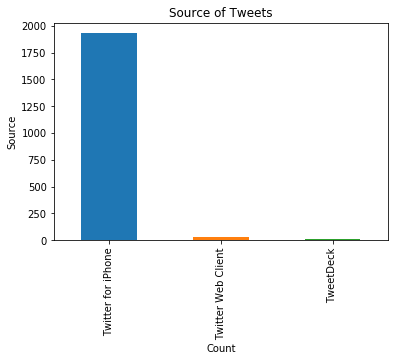

In [62]:
twitter_archive_master.source.value_counts().plot(kind = 'bar')
plt.title('Source of Tweets')
plt.xlabel('Count')
plt.ylabel('Source')

In [63]:
twitter_archive_master.source.value_counts()

Twitter for iPhone    1930
Twitter Web Client    28  
TweetDeck             9   
Name: source, dtype: int64

About 98% of the tweets in the weratedog archive were sent over via iphones.

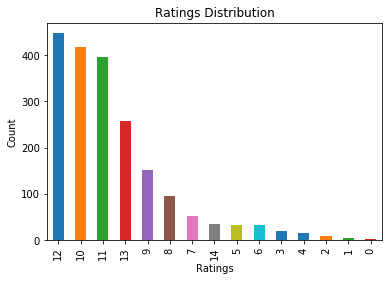

In [64]:
twitter_archive_master.rating.value_counts().plot(kind = 'bar')
plt.title('Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count');

The most common rating is 12/10 followed by 10/10 and 11/10 respectively 

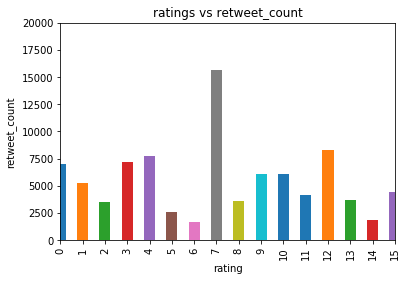

In [65]:
twitter_archive_master['retweet_count'].plot(kind = 'bar');
plt.xlim(0, 15);
plt.ylim(0, 20000);
plt.xlabel('rating');
plt.ylabel('retweet_count');
plt.title('ratings vs retweet_count');

The rating '7' had the highest number of retweets

### Insights:
1. About 98% of the tweets in the weratedog archive were sent over via iphones.

2. The most common rating is 12/10 followed by 10/10 and 11/10 respectively 

3. The rating '7' had the highest number of retweets